Hunter Bennett | Glass Lab | Kupffer Strains Project | 04 June 2021

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib_venn as venn
import seaborn as sns
from scipy.stats import betabinom, beta, binom
from scipy.optimize import fmin

matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

# Set working directory

In [2]:
dataDirectory = '/home/h1bennet/strains/data/H3K27Ac/control_f1/'
workingDirectory = '/home/h1bennet/strains_f1/results/00_CB6F1_Control/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# Read in ASBs

In [5]:
df = pd.read_csv('./peaks_with_asb_min_tag_filter.txt',
                 sep='\t',
                 index_col=0)

In [6]:
asbs = df.loc[:, 'allelic_bias_only_muts_mean_second'].tolist()

Need to fiddle with data slightly to fit to the beta distribution, in this case we will slightly move our 1 and 0 values towards 0.5

In [7]:
asbs_fixed = []
pseudocount = 0.0001

for i in asbs:
    if i == 0:
        i = i + pseudocount
    elif i == 1:
        i = i - pseudocount
    
    asbs_fixed.append(i)

Fit data to beta distribution

In [8]:
a, b, floc, fscale = beta.fit(asbs_fixed, floc=0, fscale=1)

Check quality of fit

In [11]:
beta_prob = []
beta_val = np.arange(0,1,0.001)
for i in beta_val:
    beta_prob.append(beta.pdf(i, a, b, floc, fscale))

We can see that this isn't very good, it is assuming that our biases tend more closely towards 0.5

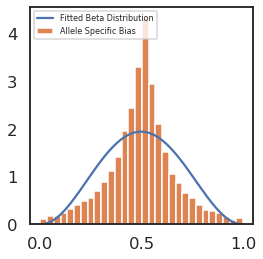

In [28]:
fig, ax = plt.subplots(figsize=(4,4))

ax.plot(beta_val, beta_prob,
        label='Fitted Beta Distribution')
ax.hist(asbs_fixed,
        bins=30,
        density=1,
        label='Allele Specific Bias');

ax.legend(fontsize=8,
          loc='upper left')

We can then try to use the beta distribution to estimate the likelihood of a given count observation.

In [15]:
beta.sf(0.602311, a, b, loc=0, scale=1)

0.30221757248592485

In [18]:
beta.cdf(0.5-(0.602311-0.5), a, b, loc=0, scale=1)

0.31129760113205773

In [21]:
beta.sf(0.99999, a, b, loc=0, scale=1)

8.881784197001252e-16

In [23]:
beta.cdf(0.0001, a, b, loc=0, scale=1)

1.9829562920684835e-12

# Binomial distribution
I think i was getting this wrong when i first thought about it, this should be modeled for each gene as the likelihood of observing the proportion of reads given the total reads.

In [24]:
df

,Chr,Start,End,Strand,Peak Score,allelic_bias_only_muts,allelic_bias_only_muts_mean_second,abs_asb_diff,location
PeakID,,,,,,,,,
Merged-chr15-65787139-4,chr15,65786655,65787655,+,1000.000000,0.600762,0.602311,0.001549,chr15:65786655-65787655
Merged-chr4-88436803-4,chr4,88436255,88437255,+,908.416687,0.427912,0.378938,0.048974,chr4:88436255-88437255
Merged-chr11-76495459-4,chr11,76494917,76495917,+,938.187500,0.504159,0.499411,0.004748,chr11:76494917-76495917
Merged-chr5-145180857-2,chr5,145180360,145181360,+,857.250000,0.504238,0.293063,0.211175,chr5:145180360-145181360
Merged-chr9-35175922-5,chr9,35175339,35176339,+,966.799988,0.465430,0.447460,0.017971,chr9:35175339-35176339
...,...,...,...,...,...,...,...,...,...
Merged-chr15-58140968-1,chr15,58140468,58141468,+,1000.000000,0.562711,0.565153,0.002442,chr15:58140468-58141468
Merged-chr2-159843478-4,chr2,159842967,159843967,+,929.750000,0.176525,0.176472,0.000053,chr2:159842967-159843967
Merged-chr5-135570083-2,chr5,135569583,135570583,+,663.000000,0.618047,0.609884,0.008163,chr5:135569583-135570583
